In [2]:
import os
from random import sample
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Must be set before importing TF to supress messages
os.environ["CUDA_VISIBLE_DEVICES"]= '2'

import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger
import numpy as np
from utils.loader import DataLoader
from utils.tools import test_model, insert_attention_layer_in_keras
from utils.data_sampler import CustomDataGenerator, CustomIterator
from utils.configs import config
from models.layers import ProjectionAttentionLayer
from typing import List
import pymf
import pandas as pd
import rsatoolbox
import matplotlib.pyplot as plt

def load_VGG_model(img_height: int, img_width: int, lr: int, loss: tf.keras.losses.Loss, metrics: List[str], trainable: True) -> tf.keras.Model:
    """ Loads VGG-16 model.

    Args:
        img_height (int): Image height.
        img_width (int): Image width.
        lr (int): Learning rate.
        loss (tf.keras.losses.Loss): Model loss.
        metrics (List[str]): Training metrics.
        trainable (True): Set if model weights should be kept frozen or not.

    Returns:
        tf.keras.Model: TensorFlow VGG-16 model.
    """
    model = tf.keras.applications.vgg16.VGG16(input_shape=(img_height, img_width, 3))
    model.trainable = trainable
    model.compile(optimizer=tf.keras.optimizers.Adam(lr, epsilon=0.1),
                loss=loss,
                metrics=metrics)

    return model

def test_model(model, test_set: CustomIterator, class_name) -> None:
    """ Test the passed model for its Top-1 accuracy on the passed test set.

    Args:
        model (Model): TensorFlow model.
        test_set (CustomIterator): Test set to test on.
    """
    test_set.reset()
    pred = model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    pred = np.argmax(pred, axis=-1)
    
    print('Computing accuracy...')
    accuracy = np.sum(pred == test_set.class_indices[class_name])/len(pred)

    return accuracy

In [3]:
# Set configs
img_height = 224
img_width = 224
batch_size = 128

test_datagen = CustomDataGenerator(
                preprocessing_function=tf.keras.applications.vgg16.preprocess_input, dtype=tf.float32)

# Load ImageNet dataset with the VGG augmentation
loader = DataLoader(batch_size, (img_height, img_width))
test_set = loader.load_test_set(aug_test=test_datagen, set_batch_size=False)

Loading test set...
Found 48238 images belonging to 1000 classes.


In [4]:
import pickle

with open('proj_mats_norm.pkl', 'rb') as f:
    p_mat_dict  = pickle.load(f)

In [5]:
classes = ['n01534433', 'n01608432', 'n01806143', 'n01820546', 'n01833805', 'n01855672', 'n02012849', 'n03887697', 'n03207941','n02906734', 'n04131690', 'n03775546', 'n04553703', 'n03207743'] 
ave = ['n01534433', 'n01608432', 'n01806143', 'n01820546', 'n01833805', 'n01855672', 'n02012849'] 
kitchen = ['n03887697', 'n03207941','n02906734', 'n04131690', 'n03775546', 'n04553703', 'n03207743']

In [6]:
dims = [17,42,90,256, 512]

In [7]:
sparsity = pd.read_csv('sparsity.csv', names=['group', 'class', 4, 17, 42, 90, 256, 512], header=0)
acc = pd.read_csv('acc.csv', names=['group', 'class', 4, 17, 42, 90, 256, 512], header=0)
acc_baseline = pd.read_csv('acc_baseline.csv', names=['group', 'class',4,  17, 42, 90, 256, 512], header=0)
fp = pd.read_csv('false_alarm.csv', names=['group', 'class', 17, 42, 90, 256, 512], header=0)
fp_baseline = pd.read_csv('false_alarm_base.csv', names=['group', 'class', 17, 42, 90, 256, 512], header=0)

In [ ]:
s_dict = {d:{} for d in dims}

for dim in dims:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    for cl in classes:
        model.load_weights(f'models/task_models_fixed/{cl}/{dim}/model_weights')
        s_dict[dim][cl] = model.get_layer('attention_block5_conv1').seeds.numpy()

In [9]:
# Get list of class folders
folder_names = list(os.walk(os.path.join(config['image_net_path'], config['test_path'])))[0][1]

sem_vec = np.load('external_files/imagenet2vec_1k.npy')
sem_dict = {}
for cl in folder_names:
    sem_dict[cl] = sem_vec[folder_names.index(cl)]

RSA

In [65]:
# Construct data dictionaries
seed_dat = {d:{} for d in dims}
sem_dat = {}

for d in dims:
    seed_dat[d]['all'] = np.vstack([seed for seed in s_dict[d].values()])
    seed_dat[d]['ave'] = np.vstack([seed for k, seed in s_dict[d].items() if k in ave])
    seed_dat[d]['kitchen'] = np.vstack([seed for k, seed in s_dict[d].items() if k in kitchen])

sem_dat['all'] = np.vstack([sem_dict[cl] for cl in classes])
sem_dat['ave'] = np.vstack([sem_dict[cl] for cl in classes if cl in ave])
sem_dat['kitchen'] = np.vstack([sem_dict[cl] for cl in classes if cl in kitchen])

In [74]:
seed_rdm = {d:{} for d in dims}
sem_rdm = {}
#obs_descriptors={'class':classes, 'super':['ave' if cl in ave else 'kitchen' for cl in classes]

for g in ['all', 'ave', 'kitchen']:
    # Semantic vectors
    data = rsatoolbox.data.Dataset(sem_dat[g], obs_descriptors={'class': classes if g=='all' else ave if g=='ave' else kitchen})
    sem_rdm[g] = rsatoolbox.rdm.calc_rdm(data, method='euclidean', descriptor='class', noise=None)

    for dim in dims:
        # Seeds
        data = rsatoolbox.data.Dataset(seed_dat[dim][g], obs_descriptors={'class': classes if g=='all' else ave if g=='ave' else kitchen})
        #noise_prec_diag = rsatoolbox.data.noise.prec_from_measurements(data, obs_desc='class', method='diag')
        seed_rdm[dim][g] = rsatoolbox.rdm.calc_rdm(data, method='euclidean', descriptor='class', noise=None)

Comparisons:
- All, Ave, Kitchen: Seed[dim] vs Sem for all dims to get correlations
- Ave, Kitchen (ALL): Seed vs Seed at different dimensions and against eachother
- Ave, Kitchen: Baseline comparisons of eachother

In [12]:
# Mean RDM Avian
mean_rdm = []
for d in dims:
    mean_rdm.append(seed_rdm[d]['ave'].get_matrices())
mean_rdm = np.concatenate(mean_rdm, axis=0)
mean_rdm = np.mean(mean_rdm, axis=0)
new_seed_ave = rsatoolbox.rdm.RDMs(np.expand_dims(mean_rdm, axis=0), pattern_descriptors={'class': ave})
m_ave = rsatoolbox.rdm.compare(new_seed_ave, sem_rdm['ave'], method='rho-a')

In [13]:
# Mean RDM Kitchen
mean_rdm = []
for d in dims:
    mean_rdm.append(seed_rdm[d]['kitchen'].get_matrices())
mean_rdm = np.concatenate(mean_rdm, axis=0)
mean_rdm = np.mean(mean_rdm, axis=0)
new_seed_kit = rsatoolbox.rdm.RDMs(np.expand_dims(mean_rdm, axis=0), pattern_descriptors={'class': kitchen},)
m_kit = rsatoolbox.rdm.compare(new_seed_kit, sem_rdm['kitchen'], method='rho-a')

(-0.6, 0.3)

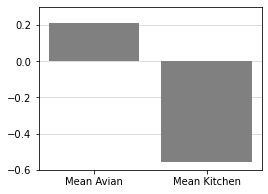

In [14]:
fig, ax1 = plt.subplots(figsize=(4,3))

ax1.bar(['Mean Avian', 'Mean Kitchen'], [float(m_ave), float(m_kit)], color='grey')
ax1.grid(color='lightgrey', linestyle='-', axis='y')
ax1.set_axisbelow(True)
ax1.set_ylim([-0.6, 0.3])

In [77]:
seed_sem = {'ave':[], 'kitchen':[]}

for g in ['ave', 'kitchen']:
    for d in dims:
        seed_sem[g].append(float(rsatoolbox.rdm.compare(seed_rdm[d][g], sem_rdm[g], method='rho-a')))

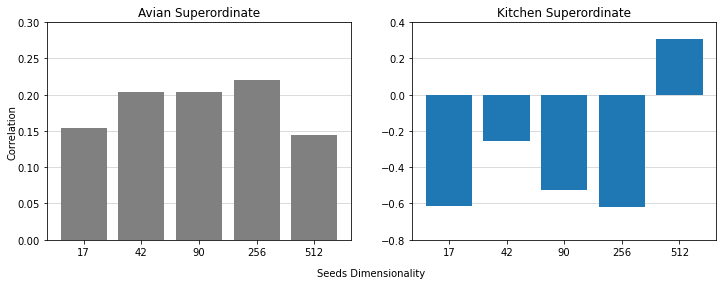

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))

ax1.bar([str(d) for d in dims], seed_sem['ave'], color='grey')
ax1.grid(color='lightgrey', linestyle='-', axis='y')
ax1.set_axisbelow(True)
ax1.set_ylim([-0.0, 0.3])
ax1.set_title('Avian Superordinate')
ax2.bar([str(d) for d in dims], seed_sem['kitchen'])
ax2.grid(color='lightgrey', linestyle='-', axis='y')
ax2.set_axisbelow(True)
ax2.set_ylim([-0.8, 0.4])
ax2.set_title('Kitchen Superordinate')
fig.text(0.5, 0.01, 'Seeds Dimensionality', ha='center', va='center')
fig.text(0.085, 0.5, 'Correlation', ha='center', va='center', rotation='vertical')
fig.savefig('rsa_main.png', dpi=300)

256 seems best for Avian due to 512 redundancies

In [58]:
seed_sem2 = {'first':[], 'sec':[]}

for i, g in enumerate([['ave', 'kitchen'], ['kitchen','ave']]):
    for d in dims:
        seed_sem2['first' if i==0 else 'sec'].append(float(rsatoolbox.rdm.compare(seed_rdm[d][g[0]], sem_rdm[g[1]], method='rho-a')))

Text(0.085, 0.5, 'Correlation')

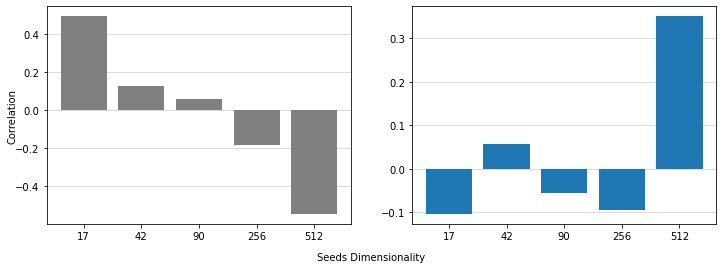

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))

ax1.bar([str(d) for d in dims], seed_sem2['first'], color='grey')
ax1.grid(color='lightgrey', linestyle='-', axis='y')
ax1.set_axisbelow(True)
#ax1.set_ylim([-0.0, 0.3])
ax2.bar([str(d) for d in dims], seed_sem2['sec'])
ax2.grid(color='lightgrey', linestyle='-', axis='y')
ax2.set_axisbelow(True)
#ax2.set_ylim([-0.8, 0.4])
fig.text(0.5, 0.01, 'Seeds Dimensionality', ha='center', va='center')
fig.text(0.085, 0.5, 'Correlation', ha='center', va='center', rotation='vertical')

Seed vs Seed

In [38]:
svs = np.zeros((len(dims), len(dims)))

for i, d in enumerate(dims):
    for j, k in enumerate(dims):
        svs[i,j] = float(rsatoolbox.rdm.compare(seed_rdm[d]['ave'], seed_rdm[k]['ave'], method='rho-a'))

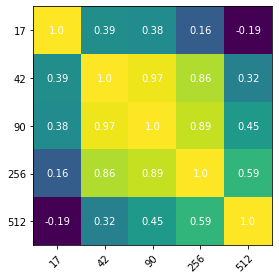

In [46]:
fig, ax = plt.subplots()
im = ax.imshow(svs)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(dims)))
ax.set_xticklabels(dims)
ax.set_yticks(np.arange(len(dims)))
ax.set_yticklabels(dims)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dims)):
    for j in range(len(dims)):
        text = ax.text(j, i, np.round(svs[i, j], 2),
                       ha="center", va="center", color="w")

#ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()
fig.savefig('seeds_vs_seeds_corr.png', dpi=300)

Visualisations

(<Figure size 288x144 with 3 Axes>,
 array([[<AxesSubplot:title={'center':'Semantic Avian Subset'}>,
         <AxesSubplot:>]], dtype=object),
 defaultdict(dict,
             {<AxesSubplot:title={'center':'Semantic Avian Subset'}>: {'image': <matplotlib.image.AxesImage at 0x7f23f820b640>,
               'y_labels': [Text(0, 0, 'n02906734'),
                Text(0, 1, 'n03207743'),
                Text(0, 2, 'n03207941'),
                Text(0, 3, 'n03775546'),
                Text(0, 4, 'n03887697'),
                Text(0, 5, 'n04131690'),
                Text(0, 6, 'n04553703')],
               'x_labels': [Text(0, 0, 'n02906734'),
                Text(1, 0, 'n03207743'),
                Text(2, 0, 'n03207941'),
                Text(3, 0, 'n03775546'),
                Text(4, 0, 'n03887697'),
                Text(5, 0, 'n04131690'),
                Text(6, 0, 'n04553703')]},
              <Figure size 288x144 with 3 Axes>: {'colorbar': <matplotlib.colorbar.Colorbar at 0x7f23d81866d0

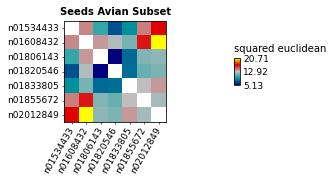

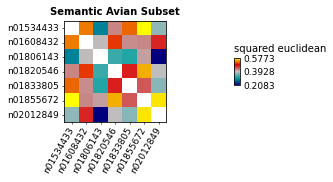

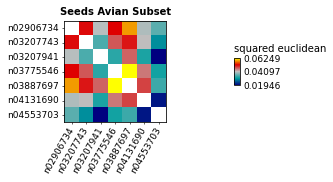

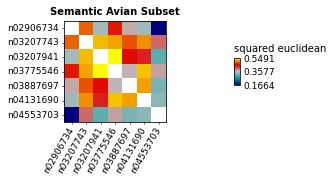

In [27]:
rsatoolbox.vis.show_rdm((seed_rdm[256]['ave']),
             rdm_descriptor='Seeds Avian Subset',
             show_colorbar='figure',
             pattern_descriptor='class')
rsatoolbox.vis.show_rdm((sem_rdm['ave']),
             rdm_descriptor='Semantic Avian Subset',
             show_colorbar='figure',
             pattern_descriptor='class')
rsatoolbox.vis.show_rdm((seed_rdm[512]['kitchen']),
             rdm_descriptor='Seeds Avian Subset',
             show_colorbar='figure',
             pattern_descriptor='class')
rsatoolbox.vis.show_rdm((sem_rdm['kitchen']),
             rdm_descriptor='Semantic Avian Subset',
             show_colorbar='figure',
             pattern_descriptor='class')

Model comparisons